In [212]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


### Företaget telco vill ha hjälp med att analysera kunder och hitta vilka som kommer lämna företaget för att kunna jobba för att behålla de kunderna. En churn modell ska tränas för att hjälpa med detta problem.

In [213]:
def any_duplicates(data:str) -> str:
    """
        Prints whether or not there are duplicates.
    """
    import pandas as pd
    
    list_with_false_true = pd.DataFrame.duplicated(data)
    any_true = list_with_false_true.any()
    if any_true:
        print("Number of duplicates: ", list_with_false_true.value_counts()[1] )
    else:
        print("No duplicates found")

In [214]:
def encode_columns(df):
    columns = df.columns
    for c in columns:
        le = LabelEncoder()
        le.fit(df[c])
        df[c] = le.transform(df[c])
    return df

### Läser av datasetet

In [215]:
churn_test_df = pd.read_csv("C:/Users/danij/OneDrive/Machine Learning/Matematik/LinearRegression/Uppgift7/churn_test.csv")
churn_train_df = pd.read_csv("C:/Users/danij/OneDrive/Machine Learning/Matematik/LinearRegression/Uppgift7/churn_train.csv")

### Inspekterar train datan

In [216]:
churn_train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [217]:
churn_train_df.shape

(5634, 21)

In [218]:
churn_train_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [219]:
churn_train_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [220]:
churn_train_df.isna().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [221]:
any_duplicates(churn_train_df)

No duplicates found


### Fördelning av target datan
Ungefär en fjärdedel av datan är positiva på att churnas, vilket är inte jämt fördelad. Och detta kan påverka vår undersökning/ resultat så att det blir problem falsk.

<AxesSubplot:>

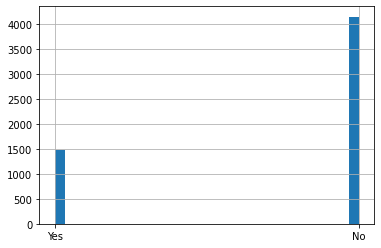

In [222]:
churn_train_df["Churn"].hist(bins=30)

In [223]:
churn_train_df['TotalCharges'] = churn_train_df.TotalCharges.replace({' ': 0})
churn_train_df['TotalCharges'] = pd.to_numeric(churn_train_df.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(churn_train_df.info())


churn_train_df = churn_train_df.drop('customerID', axis=1)

churn_train_df['Churn'] = churn_train_df.Churn.replace({'No': 0, 'Yes':1})

In [224]:
churn_test_df['TotalCharges'] = churn_test_df.TotalCharges.replace({' ': 0})
churn_test_df['TotalCharges'] = pd.to_numeric(churn_test_df.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(churn_test_df.info())


churn_test_df = churn_test_df.drop('customerID', axis=1)

churn_test_df['Churn'] = churn_test_df.Churn.replace({'No': 0, 'Yes':1})

In [225]:
churn_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5634 non-null   object 
 4   tenure            5634 non-null   int64  
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5634 non-null   object 


In [226]:
churn_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1409 non-null   object 
 1   SeniorCitizen     1409 non-null   int64  
 2   Partner           1409 non-null   object 
 3   Dependents        1409 non-null   object 
 4   tenure            1409 non-null   int64  
 5   PhoneService      1409 non-null   object 
 6   MultipleLines     1409 non-null   object 
 7   InternetService   1409 non-null   object 
 8   OnlineSecurity    1409 non-null   object 
 9   OnlineBackup      1409 non-null   object 
 10  DeviceProtection  1409 non-null   object 
 11  TechSupport       1409 non-null   object 
 12  StreamingTV       1409 non-null   object 
 13  StreamingMovies   1409 non-null   object 
 14  Contract          1409 non-null   object 
 15  PaperlessBilling  1409 non-null   object 
 16  PaymentMethod     1409 non-null   object 


In [227]:

# Function to check if a string can be converted to a float
def is_convertible(value):
    """
    Checks to see whether a string can be converted to a float.
    Input:
        - A string
    Output:
        - A boolean indicating whether or not the string can be converted to a float
    """
    try:
        float(value)
        return True
    except ValueError:
        return False
        
# Initialize list of strings that can't be converted to a float
unconvertibles = []

# Iterate through an array of strings, and append unconvertible strings to a list
str_array = churn_test_df['TotalCharges'].to_numpy()
for element in str_array:
    if is_convertible(element) == False:
        unconvertibles.append(element)

# See which strings (if any) are unconvertible
print("Unconvertibles:  ", unconvertibles)
print("Count of unconvertibles:  ", len(unconvertibles))

Unconvertibles:   []
Count of unconvertibles:   0


### Inspekterar test datan

In [228]:
churn_test_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,Yes,3,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,No,Mailed check,40.30,92.50,0
1,Male,0,No,No,42,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.75,4273.45,1
2,Male,0,Yes,Yes,43,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.30,4451.85,0
3,Female,1,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,70.60,70.60,0
4,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,1


In [229]:
churn_test_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

### Encodar strängar till integers

In [230]:
train_df = encode_columns(churn_train_df)
test_df = encode_columns(churn_test_df)

In [231]:
train_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,2,93,56,1
1,1,0,0,0,5,1,0,2,1,1,1,1,1,1,0,0,1,29,413,0
2,0,1,1,0,60,1,2,1,2,2,2,2,2,2,2,1,0,1477,5007,0
3,0,0,0,0,5,1,0,2,1,1,1,1,1,1,0,1,3,38,442,0
4,1,0,1,1,45,1,2,1,0,2,2,0,0,2,1,1,1,1125,4120,0


### Kallar fram xgboost klassifieraren

In [232]:
xgboost_clf = xgb.XGBClassifier(n_estimators= 30, learning_rate=0.1)

### Tränar xgboost

In [233]:
x_train = train_df.drop(columns="Churn")
y_train = train_df.Churn

x_test = test_df.drop(columns="Churn")
y_test = test_df.Churn

In [234]:
xgboost_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Prediktar svaret

In [235]:
y_pred = xgboost_clf.predict(x_test)

### Accuracy

In [236]:
accuracy_score(y_test, y_pred)

0.78708303761533

### Confusion Matrix

c:\Users\danij\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


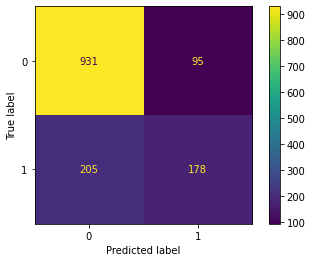

In [239]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgboost_clf, x_test, y_test)

### Attribut med störst påverkan

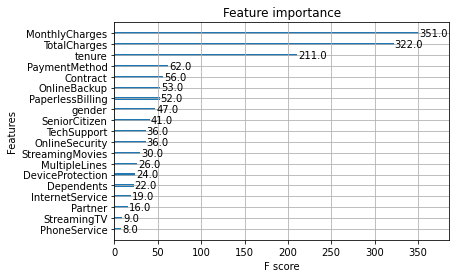

In [237]:
from xgboost import plot_importance
plot_importance(xgboost_clf)
plt.show()